# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import import_ipynb
import pandas as pd
import os

try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from SpatialTemporal_Correlation_and_Convolution import STconvolve
%matplotlib inline

importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


In [2]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [3]:
def ParaTrans(ASparadict, mag):     # because of overfitting, I assume alpha = mag*beta
    for k in ASparadict.keys():
        globals()[k] = ASparadict[k]
    global beta, alpha, g, l, Amp 
    
    beta = epsilon*2/(1+mag)
    alpha = epsilon*2*mag/(1+mag)
    g = omegastar**2 + (alpha-beta)**2 /4
    l = ((2*omegastar*np.tan(deltastar)*(-beta+gamma)+(alpha-beta)*(beta-gamma)+2*g)/
                (g*(-alpha-beta+2*gamma-2*omegastar*np.tan(deltastar))))
    Amp = Dmp*(g+alpha*beta-alpha*gamma-beta*gamma+gamma**2)/(-beta+gamma+g*l)
    DiffParadict = {'alpha':[], 'beta':[], 'gamma':[], 'g':[], 'l':[], 'tau_y':[], 'Amp':[], 'error':[]}
    for k in DiffParadict.keys():
        DiffParadict[k] = globals()[k]
    return DiffParadict

In [4]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, HeadWeight=60):
    klen = min(max(sigma_dict.values())*8, int(stimulus.shape[1]/2))
    xx = np.arange(0,klen+dx,dx)
    xx = np.append(-np.flip(xx),xx[1:])
#     print(xx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
    plt.plot(KH)
    plt.plot(np.flip(KH))
    
    T  = np.arange(0,int(para_dict['tau_y']/dt*15))*dt
    Ky = T/para_dict['tau_y'] /para_dict['tau_y'] *np.exp(-T/para_dict['tau_y'])
    sstm = np.array([np.convolve(stimulus[:,j], Ky, 'full')[:stimulus.shape[0]]*dt for j in range(stimulus.shape[1])]).T

    zts = np.zeros_like(stimulus)#Cone
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#Bipolar
    
    IHeadto = stimulus.shape[0]
    HeadTaxis = np.arange(0, IHeadto*dt, dt)
    LongHeadTaxis = np.arange(0, IHeadto*dt-dt+dt/HeadWeight/2, dt/HeadWeight)
    if LongHeadTaxis[-1]>HeadTaxis[-1]: LongHeadTaxis[-1]=HeadTaxis[-1]
    HeadStimulus = interpolate.interp1d(HeadTaxis, sstm, axis = 0)(LongHeadTaxis)
    Hzts = np.zeros_like(HeadStimulus)#horizontal
    Hyts = np.zeros_like(HeadStimulus)#horizontal
    Hwts = np.zeros_like(HeadStimulus)#horizontal
    for i in np.arange(np.shape(HeadStimulus)[0]-1):
        s = HeadStimulus[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(Hyts[i,:],KC,'same')*dx
        dyj =(-para_dict['alpha']*Hyts[i,:] + rs-Hzts[i,:])*dt/HeadWeight
        rzs = np.convolve(Hzts[i,:],KC,'same')*dx
        dzj =(-para_dict['beta'] *Hzts[i,:] + para_dict['g']*ry2z)*dt/HeadWeight
        ry2w = np.convolve(Hyts[i,:],KB,'same')*dx
        rz2w = np.convolve(Hzts[i,:],KH,'same')*dx
        dwj =(-para_dict['gamma']*Hwts[i,:] + ry2w-para_dict['l']*rz2w)*dt/HeadWeight
        Hyts[i+1,:] = (Hyts[i,:]+dyj)
        Hzts[i+1,:] = (Hzts[i,:]+dzj)
        Hwts[i+1,:] = (Hwts[i,:]+dwj)
    yts = (Hyts[::HeadWeight,:]+Hyts[::HeadWeight,::-1])/2
    zts = (Hzts[::HeadWeight,:]+Hzts[::HeadWeight,::-1])/2
    wts = (Hwts[::HeadWeight,:]+Hwts[::HeadWeight,::-1])/2

        
    return para_dict['Amp']*wts, zts, yts

# Setting parameters from fitting real TK

In [5]:
loadfiles = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\Analyzed_data\\fitNGD2LASpara.npz', allow_pickle=True)
for k in loadfiles.files:
    vars()[k] = loadfiles[k][()]
cn = 9
pd.DataFrame(para_dict).loc[cn-1]

epsilon       7.163241
gamma        34.901452
omegastar    20.631698
deltastar    -0.450280
tau_y         0.028650
Dmp           3.389743
error         1.308050
Name: 8, dtype: float64

In [6]:
FBFF_sigma_dict = dict()
FBFF_sigma_dict['B'] = 0.32/1.5 #mm from exp data (RF radius = 1.5*sigma)
FBFF_sigma_dict['H'] = 3*FBFF_sigma_dict['B']
FBFF_sigma_dict['C'] = 0.1*FBFF_sigma_dict['B'] # has to be small enough

dx = 0.01 #Note OLED micro2pixel = 7.6
hXstep =  int(10. /dx) #Half length of xais, (mm)
SKxaxis = np.arange(-hXstep,hXstep+1)*dx


dt=0.01 #large dt will cause  overflow
Tstep = int(1./dt)
TKtaxis = np.arange(Tstep)*dt

FBFF_para_dict  = pd.DataFrame(ParaTrans(para_dict, 1)).loc[cn-1]

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [7]:
FBFF_para_dict  = pd.DataFrame(ParaTrans(para_dict, .1)).loc[cn-1]
FBFF_para_dict

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


alpha      1.302408
beta      13.024075
gamma     34.901452
g        460.016331
l          0.021331
tau_y      0.028650
Amp      127.832600
error      1.308050
Name: 8, dtype: float64

In [8]:
FBFF_para_dict2  = pd.DataFrame(ParaTrans(para_dict, 1)).loc[cn-1]
FBFF_para_dict2

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


alpha      7.163241
beta       7.163241
gamma     34.901452
g        425.666957
l          0.009283
tau_y      0.028650
Amp      127.832600
error      1.308050
Name: 8, dtype: float64

# SK

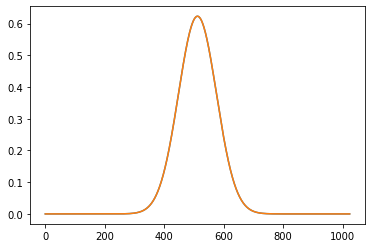

In [9]:
SDelta_input = np.zeros([Tstep, 2*hXstep+1])
SDelta_input[:, hXstep] = 1
SDelta_output_w, zts, SDelta_output_y = FB_FF_1l_1D(SDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
# SDelta_output_w2, _, _ = FB_FF_1l_1D(SDelta_input, FBFF_sigma_dict, FBFF_para_dict2, dx, dt)

Text(0.5, 1.0, 'spatial filter')

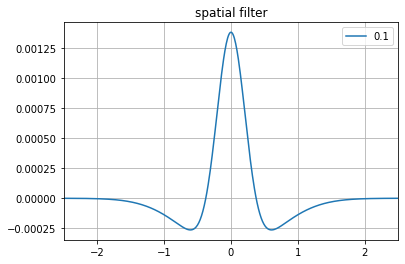

In [10]:
plt.plot(SKxaxis, SDelta_output_w[-1,:], label = '0.1')
# plt.plot(SKxaxis, SDelta_output_w2[-1,:], label = '1')
plt.legend()
plt.grid()
plt.xlim([-2.5, 2.5])
plt.title('spatial filter')

Text(0.5, 1.0, 'spatial filter')

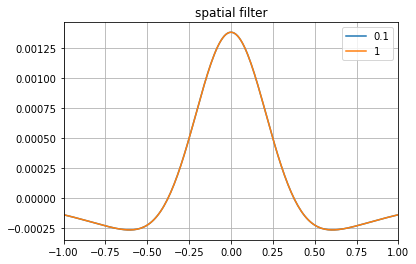

In [11]:
plt.plot(SKxaxis, np.flip(SDelta_output_w[-1,:]), label = '0.1')
plt.plot(SKxaxis, SDelta_output_w[-1,:], label = '1')
plt.legend()
plt.grid()
plt.xlim([-1, 1])
plt.title('spatial filter')

In [12]:
delSK = SDelta_output_w[-1,:]/dx
# delSK2 = SDelta_output_w2[-1,:]/dx

# STK

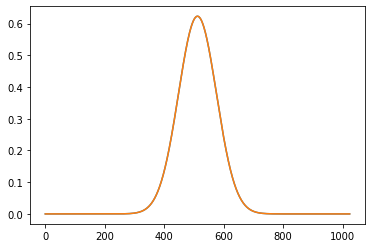

In [13]:
Delta_input = np.zeros([Tstep, 2*hXstep+1])
Delta_input[0, hXstep] = 1
Delta_output_w, zts, Delta_output_y = FB_FF_1l_1D(Delta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
# Delta_output_w2, _, _ = FB_FF_1l_1D(Delta_input, FBFF_sigma_dict, FBFF_para_dict2, dx, dt)

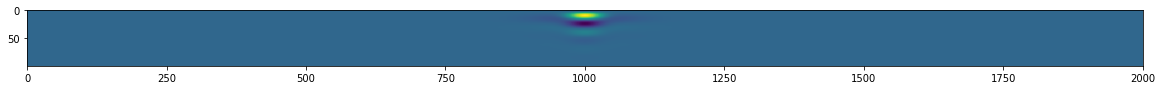

In [14]:
plt.imshow(Delta_output_w)
plt.gcf().set_size_inches(20, 5)

In [15]:
delSTK = Delta_output_w/dt/dx
# delSTK2 = Delta_output_w2/dt/dx

# SVD

In [16]:
from numpy import linalg as la
U,sigma,VT=la.svd(delSTK)
# U2,sigma2,VT2=la.svd(delSTK2)
#U and VT are unitary martrices, So U1 and V1 are normalized vector 

In [17]:
# (sigma/sum(sigma))[:5]
for i in range(2):
    if U[2,i] <0:
        VT[i,:] = -VT[i,:]
        U[:,i] = -U[:,i]
# for i in range(2):
#     if U2[2,i] <0:
#         VT2[i,:] = -VT2[i,:]
#         U2[:,i] = -U2[:,i]

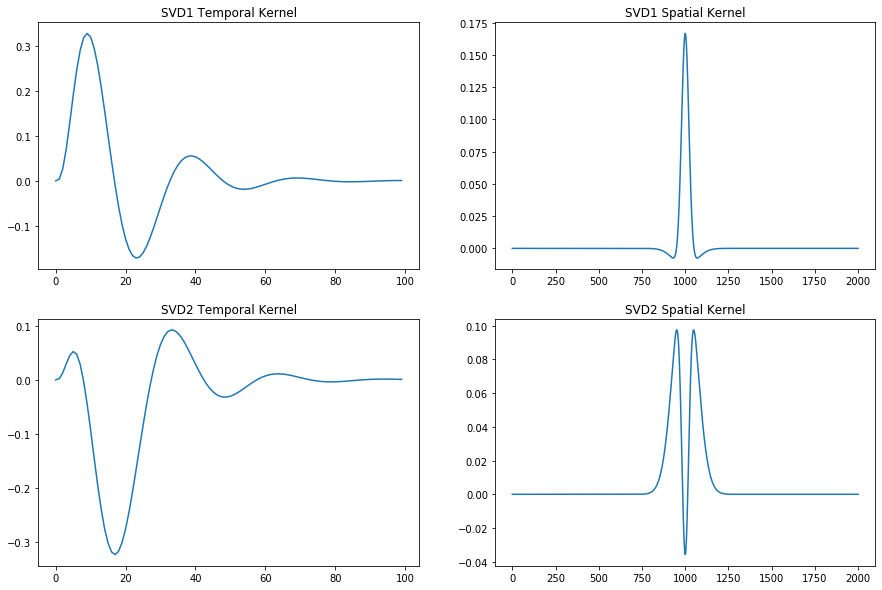

In [18]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

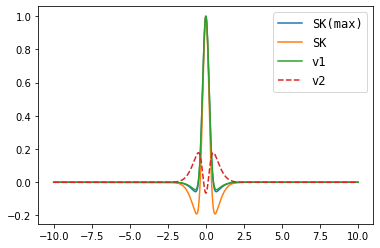

In [19]:
plt.plot(SKxaxis, delSTK[np.where(delSTK == np.max(delSTK))[0][0], :]/np.max(delSTK), label='SK(max)')
plt.plot(SKxaxis, delSK/np.max(delSK), label='SK')
plt.plot(SKxaxis, VT[0,:]/np.max(VT[0,:]), label='v1')
plt.plot(SKxaxis, VT[1,:]/np.max(VT[1,:])*sigma[1]/sigma[0], '--', label='v2')

plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

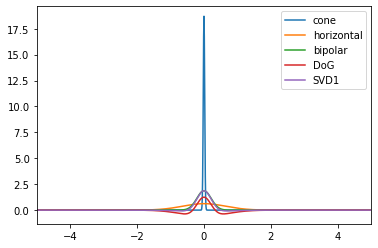

In [20]:
KC = Gaussian_filter_1d(SKxaxis,FBFF_sigma_dict['C'])
KH = Gaussian_filter_1d(SKxaxis,FBFF_sigma_dict['H'])
KB = Gaussian_filter_1d(SKxaxis,FBFF_sigma_dict['B'])
plt.plot(SKxaxis, KC, label = 'cone')
plt.plot(SKxaxis, KH, label = 'horizontal')
plt.plot(SKxaxis, KB, label = 'bipolar')
plt.plot(SKxaxis, KB-KH, label = 'DoG')
plt.plot(SKxaxis, VT[0,:]/max(VT[0,:])*max(KB), label = 'SVD1')

plt.xlim([-5,5])
plt.legend()

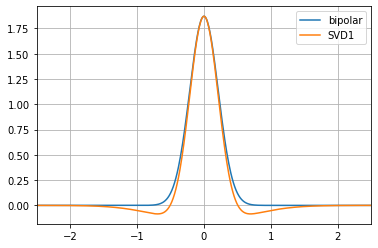

In [21]:
plt.plot(SKxaxis, KB, label = 'bipolar')
plt.grid()
plt.plot(SKxaxis, VT[0,:]/max(VT[0,:])*max(KB), label = 'SVD1')

plt.xlim([-2.5,2.5])
plt.legend()

# Fit SK with DoG

[0.09761078 0.21408776 0.02444134 0.64080764]
{'B': 0.21333333333333335, 'H': 0.64, 'C': 0.021333333333333336}


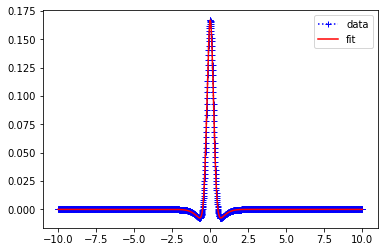

In [22]:
from scipy.optimize import curve_fit
SK = VT[0,:]

def DoG(x, a1, sigma1, a2, sigma2):
    return a1*Gaussian_filter_1d(x,sigma1)-a2*Gaussian_filter_1d(x,sigma2)

popt,pcov = curve_fit(DoG, SKxaxis, SK, p0=[max(SK), 23, 0.1*max(SK), 5*23], bounds = (0, np.inf))
# popt,pcov = curve_fit(DoG, SKxaxis, SK, p0=[max(SK)/2, 23, -0.1*max(SK), 5*23])
print(popt)
print(FBFF_sigma_dict)
plt.plot(SKxaxis, SK, 'b+:', label='data')
plt.plot(SKxaxis,  DoG(SKxaxis, *popt), 'r-', label='fit')
plt.legend()

[0.08302718 0.19563322]
{'B': 0.21333333333333335, 'H': 0.64, 'C': 0.021333333333333336}


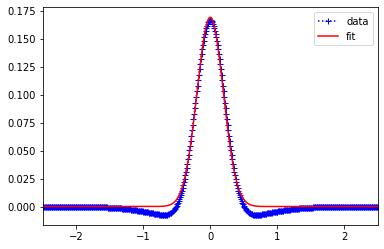

In [23]:
from scipy.optimize import curve_fit
SK = VT[0,:]

def DoG(x, a1, sigma1, a2, sigma2):
    return a1*Gaussian_filter_1d(x,sigma1)-a2*Gaussian_filter_1d(x,sigma2)
def Gaussian(x, a1, sigma1):
    return a1*Gaussian_filter_1d(x,sigma1)

# popt,pcov = curve_fit(DoG, SKxaxis, SK, p0=[max(SK), 23, 0.1*max(SK), 5*23], bounds = (0, np.inf))
popt,pcov = curve_fit(Gaussian, SKxaxis, SK, p0=[max(SK), 23], bounds = (0, np.inf))
print(popt)
print(FBFF_sigma_dict)
plt.plot(SKxaxis, SK, 'b+:', label='data')
# plt.plot(SKxaxis,  DoG(SKxaxis, *popt), 'r-', label='fit')
plt.plot(SKxaxis,  Gaussian(SKxaxis, *popt), 'r-', label='fit')
plt.xlim([-2.5, 2.5])
plt.legend()